# Extractive Summarization with SBERT (Refactored)

## Project Overview
This project builds an extractive summarization pipeline using Sentence-BERT (SBERT) embeddings and a lightweight feed-forward classifier. 

**Refactored Features**:
1.  **Improved Labeling**: Uses ROUGE-L **Recall** instead of F1 for better sentence selection.
2.  **Positional Features**: concatenates normalized sentence position to embeddings (Dim: 384 -> 385).
3.  **Loss Function**: Uses `BCEWithLogitsLoss` with `pos_weight` to handle class imbalance.
4.  **Inference**: Restores original sentence order, uses dynamic length limit, and relaxed trigram blocking.

**Hardware**: Designed to run efficiently on a Laptop GPU (RTX 3060) or Colab.

## 1. Environment Setup

In [1]:
# Install necessary packages
# Using %pip ensures installation in the currently running Jupyter kernel
%pip install datasets transformers sentence-transformers rouge-score nltk tqdm pandas tf-keras

# IMPORTANT: If you just installed these libraries, you may need to RESTART THE KERNEL for imports to work.
# In Jupyter: Kernel -> Restart Kernel

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: datasets in c:\users\moras\appdata\local\programs\python\python310\lib\site-packages (4.4.1)




[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from nltk.tokenize import sent_tokenize
from rouge_score import rouge_scorer
from tqdm.auto import tqdm
import nltk

# Ensure NLTK data is downloaded
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    nltk.download('punkt_tab')

# Set Random Seed for Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Device Configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

c:\Users\moras\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Using device: cuda


## 2. Dataset Loading & Oracle Labeling (Improved)

**Changes**:
- **Metric**: We now use **ROUGE-L Recall** to define relevance. High recall means the sentence covers a lot of the summary's content.
- **Positional Features**: We assume the first sentences are often more important (Lead-3 bias). We will compute a normalized position feature to feed into the model.

In [3]:
# Load Dataset
print("Loading CNN/DailyMail dataset...")
dataset = load_dataset("cnn_dailymail", "3.0.0", split="train")

# Shuffle and Subset
dataset = dataset.shuffle(seed=SEED).select(range(6000))

# Split into Train/Val/Test
dataset_dict = dataset.train_test_split(test_size=0.1, seed=SEED)
train_data = dataset_dict['train']
val_data = dataset_dict['test']

print(f"Train size: {len(train_data)}")
print(f"Val size: {len(val_data)}")

Loading CNN/DailyMail dataset...
Train size: 5400
Val size: 600


In [4]:
def label_sentences(text, summary, scorer):
    """
    Splits text into sentences and generates binary labels based on ROUGE-L Recall.
    """
    sentences = sent_tokenize(text)
    
    # Filter sentences by length
    valid_sentences = []
    original_indices = []
    for i, s in enumerate(sentences):
        word_count = len(s.split())
        if 3 <= word_count <= 150: # Slightly relaxed upper bound
            valid_sentences.append(s)
            original_indices.append(i)
            
    if not valid_sentences:
        return [], []

    # Calculate ROUGE Recall for each sentence
    sentence_scores = []
    for s in valid_sentences:
        # USE RECALL to find sentences that cover the summary best
        score = scorer.score(summary, s)['rougeL'].recall
        sentence_scores.append(score)
    
    # Labeling Strategy: Top-k (max 3) relevant sentences with score > 0.15
    labels = [0] * len(valid_sentences)
    sentence_scores = np.array(sentence_scores)
    
    # Get indices sorted by score (descending)
    sorted_indices = np.argsort(sentence_scores)[::-1]
    
    count = 0
    for idx in sorted_indices:
        if sentence_scores[idx] > 0.15:
            labels[idx] = 1
            count += 1
            if count >= 3:
                break
    
    # Fallback: If no good match found but we have sentences, pick the single best one
    if count == 0 and len(labels) > 0:
        best_idx = sorted_indices[0]
        labels[best_idx] = 1
        
    return valid_sentences, labels

## 3. Pre-computing Embeddings + Positional Features

We use **all-MiniLM-L6-v2** (384 dim) + **Positional Scalar** (1 dim) = **385 dim**.

**Positional Feature**: `index / total_sentences`. This gives the model a hint that earlier sentences are usually more important (Lead Bias).

In [5]:
# Initialize SBERT model
sbert_model = SentenceTransformer('all-MiniLM-L6-v2', device=DEVICE)
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

def process_and_cache_data(data_split, save_name):
    """
    Orchestrates the pipeline: Tokenize -> Oracle Label -> Embed + Position -> Save
    """
    if os.path.exists(save_name):
        print(f"Loading cached data from {save_name}...")
        # Security: Allow only weights, but since we save custom dict, we might need default loader safety checked later
        # For torch.load in standard workflow, standard load is fine for local files
        return torch.load(save_name, weights_only=False) 
    
    print(f"Processing {save_name}...")
    all_features = []
    all_labels = []
    
    for idx, item in enumerate(tqdm(data_split)):
        text = item['article']
        summary = item['highlights']
        
        # 1. Oracle Labeling
        sentences, labels = label_sentences(text, summary, scorer)
        
        if not sentences:
            continue
            
        # 2. Compute Embeddings
        embeddings = sbert_model.encode(sentences, convert_to_tensor=True, show_progress_bar=False)
        
        # 3. Add Positional Feature
        num_sents = len(sentences)
        # Create position tensor: [0, 1, ..., N-1] / N
        positions = torch.arange(num_sents, device=DEVICE, dtype=torch.float32) / (num_sents + 1e-6)
        positions = positions.unsqueeze(1) # Shape (N, 1)
        
        # Concatenate: [Emb (384) | Pos (1)] -> (N, 385)
        features = torch.cat([embeddings, positions], dim=1)
        
        all_features.append(features.cpu())
        all_labels.append(torch.tensor(labels, dtype=torch.float32))
    
    concatenated_features = torch.cat(all_features, dim=0)
    concatenated_labels = torch.cat(all_labels, dim=0)
    
    data = {'embeddings': concatenated_features, 'labels': concatenated_labels}
    torch.save(data, save_name)
    print(f"Saved to {save_name}")
    return data

# Create/Load Processed Data (v2 to distinguish from old cache)
train_processed = process_and_cache_data(train_data, 'train_sbert_data_v2.pt')
val_processed = process_and_cache_data(val_data, 'val_sbert_data_v2.pt')

Processing train_sbert_data_v2.pt...


100%|██████████| 5400/5400 [04:07<00:00, 21.81it/s]


Saved to train_sbert_data_v2.pt
Processing val_sbert_data_v2.pt...


100%|██████████| 600/600 [00:26<00:00, 22.71it/s]

Saved to val_sbert_data_v2.pt


## 4. Dataset Class & Loader

In [6]:
class SBERTDataset(Dataset):
    def __init__(self, data_dict):
        self.embeddings = data_dict['embeddings']
        self.labels = data_dict['labels']
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

BATCH_SIZE = 32

train_dataset = SBERTDataset(train_processed)
val_dataset = SBERTDataset(val_processed)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Total training sentences: {len(train_dataset)}")

Total training sentences: 197554


## 5. Model Definition (BCEWithLogits)

**Changes**:
- **Input Dim**: 385
- **Output**: Linear (No Sigmoid). We use `BCEWithLogitsLoss` for numerical stability.
- **Dropout**: Added for regularization.

In [7]:
class ExtractiveSummarizer(nn.Module):
    def __init__(self, input_dim=385, hidden_dim=128, dropout=0.2):
        super(ExtractiveSummarizer, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1)
            # No Sigmoid here! included in loss
        )
        
    def forward(self, x):
        return self.classifier(x)

model = ExtractiveSummarizer().to(DEVICE)
print(model)

ExtractiveSummarizer(
  (classifier): Sequential(
    (0): Linear(in_features=385, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
)


## 6. Training Loop (Class Weighted)

We calculate `pos_weight` to handle the fact that there are many more "0" labels (irrelevant sentences) than "1" labels.

In [8]:
# Calculate Class Weight
all_labels = train_dataset.labels
num_pos = torch.sum(all_labels)
num_neg = len(all_labels) - num_pos
pos_weight = num_neg / num_pos

print(f"Positive samples: {num_pos}, Negative samples: {num_neg}")
print(f"Calculated pos_weight: {pos_weight:.2f}")

# Loss with weighting
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(DEVICE))
optimizer = optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 4
best_val_loss = float('inf')
history = {'train_loss': [], 'val_loss': []}

print("Starting Training...")
for epoch in range(EPOCHS):
    # Training Phase
    model.train()
    train_loss = 0
    for features, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        features, labels = features.to(DEVICE), labels.to(DEVICE)
        labels = labels.unsqueeze(1)
        
        optimizer.zero_grad()
        logits = model(features)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    
    # Validation Phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for features, labels in val_loader:
            features, labels = features.to(DEVICE), labels.to(DEVICE)
            labels = labels.unsqueeze(1)
            logits = model(features)
            loss = criterion(logits, labels)
            val_loss += loss.item()
            
    avg_val_loss = val_loss / len(val_loader)
    
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    
    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_summarizer_v2.pth')
        print("  -> Saved Best Model")

Positive samples: 13832.0, Negative samples: 183722.0
Calculated pos_weight: 13.28
Starting Training...


Epoch 1/4: 100%|██████████| 6174/6174 [00:15<00:00, 397.32it/s]


Epoch 1 | Train Loss: 1.0087 | Val Loss: 1.0024
  -> Saved Best Model


Epoch 2/4: 100%|██████████| 6174/6174 [00:08<00:00, 695.20it/s]


Epoch 2 | Train Loss: 0.9579 | Val Loss: 0.9948
  -> Saved Best Model


Epoch 3/4: 100%|██████████| 6174/6174 [00:08<00:00, 692.69it/s]


Epoch 3 | Train Loss: 0.9302 | Val Loss: 0.9870
  -> Saved Best Model


Epoch 4/4: 100%|██████████| 6174/6174 [00:11<00:00, 533.06it/s]


Epoch 4 | Train Loss: 0.9043 | Val Loss: 0.9785
  -> Saved Best Model


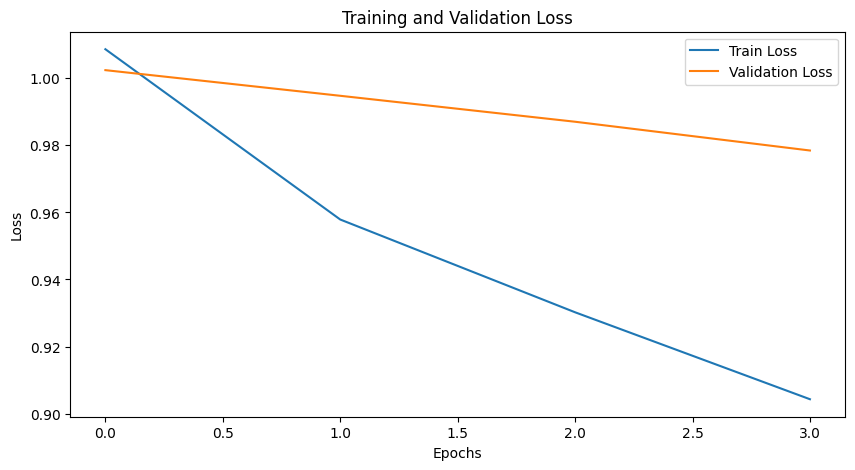

In [9]:
# Visualizing Loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 7. Inference & Summarization (Advanced)

**Features**:
1.  **Positional Feature Generation**: Created on the fly.
2.  **Sigmoid Activation**: Applied to raw logits.
3.  **Dynamic Length**: Stops adding sentences when word count > 100.
4.  **Order Restoration**: Sentences are re-sorted to match document flow.
5.  **Relaxed Blocking**: Allows 1 overlapping trigram, blocks if > 1.

In [10]:
def has_trigram_overlap(candidate, summary_sentences, tolerance=1):
    """
    Rejects if candidate shares MORE THAN 'tolerance' trigrams with summary.
    """
    tri_c = set(nltk.ngrams(candidate.lower().split(), 3))
    if not tri_c: return False
    
    overlap_count = 0
    for s in summary_sentences:
        tri_s = set(nltk.ngrams(s.lower().split(), 3))
        # Count intersection size
        overlaps = len(tri_c.intersection(tri_s))
        overlap_count += overlaps
    
    return overlap_count > tolerance

def summarize_text(text, model, max_words=100):
    """
    Full inference pipeline with dynamic length and re-ordering.
    """
    # 1. Split sentences
    sentences = sent_tokenize(text)
    valid_sentences = []
    original_indices = []
    for i, s in enumerate(sentences):
        if 3 <= len(s.split()) <= 200:
            valid_sentences.append(s)
            original_indices.append(i)
            
    if not valid_sentences:
        return ""
    
    # 2. Embed + Position
    embeddings = sbert_model.encode(valid_sentences, convert_to_tensor=True)
    num_sents = len(valid_sentences)
    positions = torch.arange(num_sents, device=DEVICE, dtype=torch.float32) / (num_sents + 1e-6)
    positions = positions.unsqueeze(1)
    
    features = torch.cat([embeddings, positions.to(DEVICE)], dim=1)
    
    # 3. Predict
    model.eval()
    with torch.no_grad():
        logits = model(features).cpu().squeeze()
        scores = torch.sigmoid(logits).numpy()
        
    if scores.ndim == 0:
        scores = np.array([scores])
    
    # 4. Selection
    sorted_indices = np.argsort(scores)[::-1]
    
    selected_data = [] # Stores (original_index, sentence)
    current_words = 0
    
    summary_sentences_so_far = []

    for idx in sorted_indices:
        candidate = valid_sentences[idx]
        orig_idx = original_indices[idx]
        candidate_words = len(candidate.split())
        
        # Check length constraint
        if current_words + candidate_words > max_words + 20: # Allow slight overflow
            continue
            
        # Check redundancy
        if not has_trigram_overlap(candidate, summary_sentences_so_far):
            selected_data.append((orig_idx, candidate))
            summary_sentences_so_far.append(candidate)
            current_words += candidate_words
            
            if current_words >= max_words:
                break
    
    # 5. Restore Order
    selected_data.sort(key=lambda x: x[0])
    final_sentences = [x[1] for x in selected_data]
    
    return " ".join(final_sentences)

## 8. Evaluation

Evaluated on held-out **Test Set** (dataset_dict['test']). Reported as Mean scores.

In [11]:
# Load clean weights
model.load_state_dict(torch.load('best_summarizer_v2.pth', weights_only=True))

# Use actual test split for evaluation (first 50-100 samples for speed)
test_subset = dataset_dict['test'].select(range(50))
rouge_eval = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

results = []
references = []
predictions = []

print("Evaluating...")
for item in tqdm(test_subset):
    article = item['article']
    ref_summary = item['highlights']
    
    pred_summary = summarize_text(article, model, max_words=100)
    
    scores = rouge_eval.score(ref_summary, pred_summary)
    results.append({
        'R1': scores['rouge1'].fmeasure,
        'R2': scores['rouge2'].fmeasure,
        'RL': scores['rougeL'].fmeasure
    })
    references.append(ref_summary)
    predictions.append(pred_summary)

df_results = pd.DataFrame(results)
print("\nAverage ROUGE Scores:")
print(df_results.mean())

Evaluating...


100%|██████████| 50/50 [00:01<00:00, 43.94it/s]


Average ROUGE Scores:
R1    0.357085
R2    0.175300
RL    0.256562
dtype: float64


In [12]:
pd.set_option('display.max_colwidth', 150)
df_examples = pd.DataFrame({'Reference': references, 'Prediction': predictions})
display(df_examples.head(5))

,Reference,Prediction
0,"Richard Charles Henderson, 35, snapped the blurry image of the twister and sent it to pal George 'Sonny' Slay at around 6:05 p.m. on Friday .\nThe...","The chase: Richard Charles Henderson, pictured, died Friday as he chased a deadly twister through El Reno . Richard Charles Henderson, 35, snapped..."
1,33-year old Jon Egging pronounced dead at scene .\nMayday call made at 1.50pm - then the aircraft crashed .\nRed Arrows had performed at Bournemou...,Fatal: Flight Lieutenant Jon Egging was flying Red 4 when his aircraft ran into difficulty . Bournemouth Air Festival to stage an afternoon fly-pa...
2,"Mary Willingham exposed how UNC enrolls student-athletes reading at low levels .\nUNC review, involving three experts, says there were flaws in he...",The University of North Carolina says that three independent experts in the field of adult literacy have finished a university-commissioned review...
3,Zoe Wanamaker: 'I don't know really what iambic pentameter is'\nSir Michael Gambon admits he is 'frightened' by England's national poet .\nMark Ry...,Many of Britain's biggest stars of stage and screen admit they struggle to understand Shakespeare because of the way they were taught the Bard's p...
4,Home of SASS & Bide co-founder Sarah-Jane Clarke and husband landscape architect Daniel Baffsky has been put up for sale .\nClarke with Heidi Midd...,The stunning home of SASS & Bide co-founder Sarah-Jane Clarke and husband landscape architect Daniel Baffsky has been put up for sale and it can b...
